In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from schemas import DataCatalog
import constants as const
from ons_population import ONSPopulationScenario
import seaborn as sns

In [3]:
#Loading Data-catalog
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

## **Loading & Preprocessing the Dataset - 'Patients Registered at a GP practice, October 2023'**

In [4]:
#Loading the Dataset to get data on number of patients
gp_patients_reg_catalog_entry = catalog.single_data_sources[6]
gp_patients_reg = gp_patients_reg_catalog_entry.load()
print(gp_patients_reg_catalog_entry.zip_file.namelist())
print(gp_patients_reg.shape)
gp_patients_reg.head()

['gp-reg-pat-prac-quin-age.csv']
(334411, 9)


/workspaces/PrimaryCareDemandAndCapacity/schemas.py:146: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_file, **read_csv_kwargs)


,PUBLICATION,EXTRACT_DATE,ORG_TYPE,ORG_CODE,ONS_CODE,POSTCODE,SEX,AGE_GROUP_5,NUMBER_OF_PATIENTS
0,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,ALL,ALL,10927943
1,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,FEMALE,0_4,258852
2,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,FEMALE,10_14,300771
3,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,FEMALE,15_19,287618
4,GP_PRAC_PAT_LIST,01Oct2023,Comm Region,Y56,E40000003,NaN,FEMALE,20_24,385681


In [5]:
print(gp_patients_reg['AGE_GROUP_5'].unique())

['ALL' '0_4' '10_14' '15_19' '20_24' '25_29' '30_34' '35_39' '40_44'
 '45_49' '50_54' '55_59' '5_9' '60_64' '65_69' '70_74' '75_79' '80_84'
 '85_89' '90_94' '95+']


In [6]:
#Replacing AGE_BANDS values to match the ONS_projection AGE_BANDS
gp_patients_reg['AGE_GROUP_5'] = gp_patients_reg['AGE_GROUP_5'].replace({'90_94':'90+', '95+':'90+', '0_4':'0-4', '5_9':'5-9', '10_14':'10-14', '15_19':'15-19', '20_24':'20-24', '25_29':'25-29',
                                                                         '30_34':'30-34', '35_39':'35-39', '40_44':'40-44', '45_49':'45-49', '50_54':'50-54', '55_59':'55-59', '60_64':'60-64',
                                                                         '65_69':'65-69', '70_74':'70-74', '75_79':'75-79', '80_84':'80-84', '85_89':'85-89'})

#Renaming the column name to match with ONS projection data
gp_patients_reg = gp_patients_reg.rename(columns={'ONS_CODE':'AREA_CODE'})

#Dropping unused columns and rows corrsponding to 'ALL' for AGE_GROUP_5 
gp_patients_reg = gp_patients_reg.loc[gp_patients_reg['AGE_GROUP_5']!='ALL'].drop(columns=['PUBLICATION','EXTRACT_DATE','ORG_TYPE','POSTCODE','SEX']).set_index('AREA_CODE')

print(gp_patients_reg['AGE_GROUP_5'].unique())
print(gp_patients_reg.shape)
gp_patients_reg.head()

['0-4' '10-14' '15-19' '20-24' '25-29' '30-34' '35-39' '40-44' '45-49'
 '50-54' '55-59' '5-9' '60-64' '65-69' '70-74' '75-79' '80-84' '85-89'
 '90+']
(311080, 3)


,ORG_CODE,AGE_GROUP_5,NUMBER_OF_PATIENTS
AREA_CODE,,,
E40000003,Y56,0-4,258852
E40000003,Y56,10-14,300771
E40000003,Y56,15-19,287618
E40000003,Y56,20-24,385681
E40000003,Y56,25-29,535500


### **Filtering the data for Sub-ICB's under SNEE ICB**

In [7]:
required_icb_code = ['06L', '06T', '07K']
snee_gp_patients_reg = gp_patients_reg[gp_patients_reg['ORG_CODE'].isin(required_icb_code)].groupby(['AREA_CODE','AGE_GROUP_5']).sum().drop(columns=['ORG_CODE'])

#The dataframe that will be combined later with ONS projection factors dataframe
snee_gp_patients_reg

NUMBER_OF_PATIENTS
AREA_CODE AGE_GROUP_5                    
E38000086 0-4                       18148
          10-14                     24231
          15-19                     23513
          20-24                     19718
          25-29                     22975
          30-34                     26197
          35-39                     27046
          40-44                     26757
          45-49                     24675
          5-9                       22318
          50-54                     28246
          55-59                     29474
          60-64                     27504
          65-69                     24094
          70-74                     22465
          75-79                     21514
          80-84                     13002
          85-89                      8418
          90+                        4944
E38000117 0-4                       17141
          10-14                     21753
          15-19                     19603
          20-24                     22057
          25-29                     23587
          30-34                     25308
          35-39                     23991
          40-44                     22694
          45-49                     21090
          5-9                       20542
          50-54                     23563
          55-59                     24997
          60-64                     23198
          65-69                     20141
          70-74                     19583
          75-79                     20080
          80-84                     11895
          85-89                      7241
          90+                        4104
E38000204 0-4                       12369
          10-14                     15470
          15-19                     14609
          20-24                     12434
          25-29                     15253
          30-34                     17380
          35-39                     17559
          40-44                     17408
          45-49                     16273
          5-9                       14201
          50-54                     19191
          55-59                     20598
          60-64                     18664
          65-69                     15853
          70-74                     15371
          75-79                     15362
          80-84                      9427
          85-89                      5679
          90+                        3004

## **Loading & Preprocessing the Dataset - ONS Population projections**

In [8]:
ons_projection_catalog_entry = catalog.scenario_data_sources[0].scenarios[0]
ons_projections = ons_projection_catalog_entry.load()
print(ons_projection_catalog_entry.zip_file.namelist())
print(ons_projections.shape)
ons_projections.head()

['2018 SNPP CCG pop females.csv', '2018 SNPP CCG pop males.csv', '2018 SNPP CCG pop persons.csv', 'SNPP Z2 CCG Pop_read me.txt']
(17940, 31)


,AREA_CODE,AREA_NAME,COMPONENT,SEX,AGE_GROUP,2018,2019,2020,2021,2022,...,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043
0,E38000004,NHS Barking and Dagenham CCG,Population,persons,0,3819.0,3539.476,3553.996,3545.026,3503.164,...,3485.017,3512.290,3542.499,3574.884,3607.783,3638.390,3663.012,3682.648,3697.617,3706.681
1,E38000004,NHS Barking and Dagenham CCG,Population,persons,1,3923.0,3841.214,3570.205,3583.060,3571.184,...,3482.414,3507.074,3534.224,3564.456,3597.080,3630.402,3661.624,3687.005,3707.455,3723.301
2,E38000004,NHS Barking and Dagenham CCG,Population,persons,2,4050.0,3912.292,3826.447,3565.341,3575.791,...,3448.544,3469.903,3494.032,3520.703,3550.533,3582.885,3616.072,3647.352,3672.985,3693.800
3,E38000004,NHS Barking and Dagenham CCG,Population,persons,3,3822.0,4036.658,3906.033,3816.546,3563.662,...,3426.572,3442.075,3462.911,3486.569,3512.830,3542.304,3574.383,3607.421,3638.690,3664.447
4,E38000004,NHS Barking and Dagenham CCG,Population,persons,4,3905.0,3805.264,4003.299,3879.217,3788.087,...,3394.732,3405.045,3420.062,3440.323,3463.422,3489.140,3518.097,3549.706,3582.360,3613.373


In [32]:
print(ons_projections['AGE_GROUP'].unique())

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57'
 '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71'
 '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85'
 '86' '87' '88' '89' '90 and over' 'All ages']


In [10]:
#Removing values corresponding to 'All ages' in the 'AGE_GROUP' column and dropping unused columns
ons_projections_df = ons_projections.loc[ons_projections['AGE_GROUP']!='All ages'].drop(columns=['AREA_NAME','COMPONENT','SEX','2018','2019','2020','2021','2022']).set_index('AREA_CODE')

#Replacing '90 and over' with 90
ons_projections_df['AGE_GROUP'] = ons_projections_df['AGE_GROUP'].replace('90 and over', 90)

### **Appending new column having age bands data**

In [39]:
#Specifying the bins and labels for new AGE BANDS columns
bins = [-1,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,float('inf')]
labels = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90+']

#Converting AGE_GROUP data type to int
ons_projections_df['AGE_GROUP'] = ons_projections_df['AGE_GROUP'].astype(int)

#Adding the column for Age Bands as 'AGE_GROUP_5'
ons_projections_df['AGE_GROUP_5'] = pd.cut(ons_projections_df['AGE_GROUP'], bins=bins, labels=labels)

### **Filtering the data for Sub-ICB's under SNEE ICB**

In [ ]:
#Filtering the data to keep only SNEE ICB
required_icb = ['E38000086','E38000204','E38000117']
snee_ons_projections = ons_projections_df[ons_projections_df.index.isin(required_icb)].groupby(['AREA_CODE', 'AGE_GROUP_5']).sum().drop(columns=['AGE_GROUP'])

### **Calculating the population change factor for each year keeping 2023 as baseline**

In [13]:
pop_baseline = snee_ons_projections['2023']
snee_factors_ons_projections = snee_ons_projections.div(pop_baseline, axis=0).round(4)

snee_factors_ons_projections

2023    2024    2025    2026    2027    2028    2029  \
AREA_CODE AGE_GROUP_5                                                         
E38000086 0-4           1.0  0.9964  0.9917  0.9877  0.9855  0.9836  0.9820   
          5-9           1.0  0.9819  0.9652  0.9446  0.9329  0.9236  0.9207   
          10-14         1.0  0.9968  0.9875  0.9790  0.9663  0.9565  0.9398   
          15-19         1.0  1.0130  1.0303  1.0430  1.0484  1.0430  1.0384   
          20-24         1.0  0.9898  0.9908  1.0098  1.0367  1.0657  1.0841   
          25-29         1.0  0.9897  0.9737  0.9524  0.9244  0.9083  0.9018   
          30-34         1.0  0.9922  0.9835  0.9709  0.9645  0.9582  0.9483   
          35-39         1.0  1.0162  1.0189  1.0243  1.0221  1.0115  1.0047   
          40-44         1.0  1.0009  1.0014  1.0046  1.0100  1.0252  1.0411   
          45-49         1.0  0.9938  1.0078  1.0294  1.0561  1.0734  1.0751   
          50-54         1.0  0.9717  0.9421  0.9026  0.8709  0.8451  0.8413   
          55-59         1.0  1.0003  0.9932  0.9903  0.9780  0.9663  0.9401   
          60-64         1.0  1.0295  1.0615  1.0766  1.0932  1.0950  1.0952   
          65-69         1.0  1.0162  1.0369  1.0711  1.0897  1.1153  1.1489   
          70-74         1.0  0.9932  0.9870  0.9889  1.0097  1.0334  1.0515   
          75-79         1.0  1.0269  1.0471  1.0552  1.0023  0.9793  0.9737   
          80-84         1.0  1.0527  1.1091  1.1808  1.3192  1.3917  1.4288   
          85-89         1.0  1.0304  1.0408  1.0416  1.0740  1.1191  1.1846   
          90+           1.0  1.0205  1.0539  1.0785  1.1075  1.1453  1.1830   
E38000117 0-4           1.0  1.0057  1.0098  1.0142  1.0185  1.0222  1.0258   
          5-9           1.0  0.9890  0.9786  0.9730  0.9683  0.9653  0.9690   
          10-14         1.0  1.0144  1.0224  1.0247  1.0133  1.0076  0.9959   
          15-19         1.0  1.0262  1.0578  1.0824  1.1156  1.1316  1.1455   
          20-24         1.0  1.0003  1.0075  1.0248  1.0520  1.0819  1.1049   
          25-29         1.0  0.9956  0.9956  0.9858  0.9693  0.9581  0.9544   
          30-34         1.0  1.0013  0.9877  0.9725  0.9627  0.9597  0.9537   
          35-39         1.0  1.0333  1.0608  1.0968  1.1205  1.1216  1.1212   
          40-44         1.0  1.0085  1.0194  1.0282  1.0427  1.0667  1.0964   
          45-49         1.0  1.0011  1.0100  1.0305  1.0507  1.0743  1.0833   
          50-54         1.0  0.9740  0.9592  0.9305  0.9076  0.8934  0.8954   
          55-59         1.0  1.0043  1.0007  0.9938  0.9857  0.9692  0.9459   
          60-64         1.0  1.0326  1.0576  1.0844  1.0964  1.1093  1.1140   
          65-69         1.0  1.0250  1.0553  1.0908  1.1324  1.1621  1.1995   
          70-74         1.0  0.9767  0.9692  0.9747  0.9856  1.0017  1.0272   
          75-79         1.0  1.0198  1.0272  1.0197  0.9555  0.9265  0.9081   
          80-84         1.0  1.0583  1.1073  1.1772  1.3222  1.3970  1.4254   
          85-89         1.0  1.0281  1.0430  1.0394  1.0631  1.1131  1.1845   
          90+           1.0  1.0075  1.0326  1.0493  1.0732  1.1029  1.1341   
E38000204 0-4           1.0  0.9976  0.9938  0.9907  0.9896  0.9885  0.9878   
          5-9           1.0  0.9991  1.0016  0.9878  0.9867  0.9779  0.9754   
          10-14         1.0  0.9996  0.9910  0.9869  0.9746  0.9661  0.9629   
          15-19         1.0  1.0143  1.0367  1.0639  1.0764  1.0864  1.0856   
          20-24         1.0  0.9931  0.9932  1.0069  1.0273  1.0523  1.0683   
          25-29         1.0  0.9934  0.9814  0.9646  0.9458  0.9336  0.9281   
          30-34         1.0  0.9961  0.9895  0.9784  0.9763  0.9751  0.9675   
          35-39         1.0  1.0083  1.0071  1.0096  1.0023  0.9840  0.9799   
          40-44         1.0  1.0057  1.0146  1.0250  1.0259  1.0441  1.0535   
          45-49         1.0  0.9958  1.0096  1.0273  1.0639  1.0908  1.0966   
          50-54         1.0  0.9618  0.9272  0.8855  0.8505  0.8201  0.81

In [14]:
#Converting to Dictionary
dict_data = snee_factors_ons_projections.to_dict(orient='index')
dict_data

{('E38000086', '0-4'): {'2023': 1.0,
  '2024': 0.9964,
  '2025': 0.9917,
  '2026': 0.9877,
  '2027': 0.9855,
  '2028': 0.9836,
  '2029': 0.982,
  '2030': 0.9808,
  '2031': 0.9804,
  '2032': 0.981,
  '2033': 0.9828,
  '2034': 0.9859,
  '2035': 0.9902,
  '2036': 0.9958,
  '2037': 1.0026,
  '2038': 1.0106,
  '2039': 1.0194,
  '2040': 1.0285,
  '2041': 1.0373,
  '2042': 1.0454,
  '2043': 1.0521},
 ('E38000086', '5-9'): {'2023': 1.0,
  '2024': 0.9819,
  '2025': 0.9652,
  '2026': 0.9446,
  '2027': 0.9329,
  '2028': 0.9236,
  '2029': 0.9207,
  '2030': 0.9168,
  '2031': 0.9137,
  '2032': 0.9121,
  '2033': 0.9107,
  '2034': 0.9096,
  '2035': 0.9088,
  '2036': 0.9087,
  '2037': 0.9095,
  '2038': 0.9114,
  '2039': 0.9144,
  '2040': 0.9185,
  '2041': 0.9238,
  '2042': 0.9302,
  '2043': 0.9376},
 ('E38000086', '10-14'): {'2023': 1.0,
  '2024': 0.9968,
  '2025': 0.9875,
  '2026': 0.979,
  '2027': 0.9663,
  '2028': 0.9565,
  '2029': 0.9398,
  '2030': 0.9248,
  '2031': 0.9059,
  '2032': 0.8951,
  '203

## **Combining both the dataframes for 'snee_factors_ons_projections' & 'snee_gp_patients_reg'**

In [40]:
#Using the Inner join to join both the dataframes
snee_factors_patients_df= snee_factors_ons_projections.join(snee_gp_patients_reg['NUMBER_OF_PATIENTS'])
snee_factors_patients_df.head()

2023    2024    2025    2026    2027    2028    2029  \
AREA_CODE AGE_GROUP_5                                                         
E38000086 0-4           1.0  0.9964  0.9917  0.9877  0.9855  0.9836  0.9820   
          5-9           1.0  0.9819  0.9652  0.9446  0.9329  0.9236  0.9207   
          10-14         1.0  0.9968  0.9875  0.9790  0.9663  0.9565  0.9398   
          15-19         1.0  1.0130  1.0303  1.0430  1.0484  1.0430  1.0384   
          20-24         1.0  0.9898  0.9908  1.0098  1.0367  1.0657  1.0841   

                         2030    2031    2032  ...    2035    2036    2037  \
AREA_CODE AGE_GROUP_5                          ...                           
E38000086 0-4          0.9808  0.9804  0.9810  ...  0.9902  0.9958  1.0026   
          5-9          0.9168  0.9137  0.9121  ...  0.9088  0.9087  0.9095   
          10-14        0.9248  0.9059  0.8951  ...  0.8805  0.8778  0.8764   
          15-19        1.0287  1.0233  1.0109  ...  0.9647  0.9484  0.9370   
          20-24        1.1070  1.1242  1.1367  ...  1.1379  1.1329  1.1184   

                         2038    2039    2040    2041    2042    2043  \
AREA_CODE AGE_GROUP_5                                                   
E38000086 0-4          1.0106  1.0194  1.0285  1.0373  1.0454  1.0521   
          5-9          0.9114  0.9144  0.9185  0.9238  0.9302  0.9376   
          10-14        0.8753  0.8743  0.8738  0.8738  0.8747  0.8766   
          15-19        0.9298  0.9269  0.9236  0.9212  0.9199  0.9188   
          20-24        1.1063  1.0910  1.0755  1.0561  1.0421  1.0327   

                       NUMBER_OF_PATIENTS  
AREA_CODE AGE_GROUP_5                      
E38000086 0-4                       18148  
          5-9                       22318  
          10-14                     24231  
          15-19                     23513  
          20-24                     19718  

[5 rows x 22 columns]

### **Multiplying each year's projection factor with the number of patients from GP list**

In [45]:
#Select the columns we want to multiply with
columns_to_multiply_by = snee_factors_patients_df.iloc[:, 0:21]

# Multiply the selected columns by the chosen column
result_columns = columns_to_multiply_by.multiply(snee_factors_patients_df['NUMBER_OF_PATIENTS'], axis=0).round(2)

# Create a new DataFrame with the result columns
snee_gp_projections = pd.concat([snee_factors_patients_df['NUMBER_OF_PATIENTS'], result_columns], axis=1)
snee_gp_projections.head()

NUMBER_OF_PATIENTS     2023      2024      2025  \
AREA_CODE AGE_GROUP_5                                                    
E38000086 0-4                       18148  18148.0  18082.67  17997.37   
          5-9                       22318  22318.0  21914.04  21541.33   
          10-14                     24231  24231.0  24153.46  23928.11   
          15-19                     23513  23513.0  23818.67  24225.44   
          20-24                     19718  19718.0  19516.88  19536.59   

                           2026      2027      2028      2029      2030  \
AREA_CODE AGE_GROUP_5                                                     
E38000086 0-4          17924.78  17884.85  17850.37  17821.34  17799.56   
          5-9          21081.58  20820.46  20612.90  20548.18  20461.14   
          10-14        23722.15  23414.42  23176.95  22772.29  22408.83   
          15-19        24524.06  24651.03  24524.06  24415.90  24187.82   
          20-24        19911.24  20441.65  21013.47  21376.28  21827.83   

                           2031  ...      2034      2035      2036      2037  \
AREA_CODE AGE_GROUP_5            ...                                           
E38000086 0-4          17792.30  ...  17892.11  17970.15  18071.78  18195.18   
          5-9          20391.96  ...  20300.45  20282.60  20280.37  20298.22   
          10-14        21950.86  ...  21417.78  21335.40  21269.97  21236.05   
          15-19        24060.85  ...  23085.06  22682.99  22299.73  22031.68   
          20-24        22166.98  ...  22490.35  22437.11  22338.52  22052.61   

                           2038      2039      2040      2041      2042  \
AREA_CODE AGE_GROUP_5                                                     
E38000086 0-4          18340.37  18500.07  18665.22  18824.92  18971.92   
          5-9          20340.63  20407.58  20499.08  20617.37  20760.20   
          10-14        21209.39  21185.16  21173.05  21173.05  21194.86   
          15-19        21862.39  21794.20  21716.61  21660.18  21629.61   
          20-24        21814.02  21512.34  21206.71  20824.18  20548.13   

                           2043  
AREA_CODE AGE_GROUP_5            
E38000086 0-4          19093.51  
          5-9          20925.36  
          10-14        21240.89  
          15-19        21603.74  
          20-24        20362.78  

[5 rows x 22 columns]

### **Creating visuals between ONS Projections and GP Projections (ONS projection factors*patients registered at GP list)** 

In [43]:
combined_df = snee_ons_projections.merge(snee_gp_projections, left_index=True, right_index=True, suffixes=('-ONS_Projection','-GP_Projection'))
combined_df.head()

2023-ONS_Projection  2024-ONS_Projection  \
AREA_CODE AGE_GROUP_5                                             
E38000086 0-4                    19769.942            19698.373   
          5-9                    22791.554            22378.224   
          10-14                  25096.067            25016.257   
          15-19                  23195.390            23496.655   
          20-24                  17350.547            17173.888   

                       2025-ONS_Projection  2026-ONS_Projection  \
AREA_CODE AGE_GROUP_5                                             
E38000086 0-4                    19604.966            19527.257   
          5-9                    21998.493            21529.082   
          10-14                  24783.209            24569.717   
          15-19                  23897.784            24193.275   
          20-24                  17191.096            17520.013   

                       2027-ONS_Projection  2028-ONS_Projection  \
AREA_CODE AGE_GROUP_5                                             
E38000086 0-4                    19483.805            19446.523   
          5-9                    21261.284            21050.186   
          10-14                  24249.751            24005.345   
          15-19                  24317.998            24191.858   
          20-24                  17987.881            18489.898   

                       2029-ONS_Projection  2030-ONS_Projection  \
AREA_CODE AGE_GROUP_5                                             
E38000086 0-4                    19414.341            19391.237   
          5-9                    20983.672            20896.032   
          10-14                  23584.788            23208.398   
          15-19                  24085.124            23861.980   
          20-24                  18808.913            19207.344   

                       2031-ONS_Projection  2032-ONS_Projection  ...  \
AREA_CODE AGE_GROUP_5                                            ...   
E38000086 0-4                    19381.836            19393.561  ...   
          5-9                    20825.220            20787.879  ...   
          10-14                  22734.049            22463.455  ...   
          15-19                  23735.101            23447.633  ...   
          20-24                  19504.800            19722.030  ...   

                       2034-GP_Projection  2035-GP_Projection  \
AREA_CODE AGE_GROUP_5                                           
E38000086 0-4                    17892.11            17970.15   
          5-9                    20300.45            20282.60   
          10-14                  21417.78            21335.40   
          15-19                  23085.06            22682.99   
          20-24                  22490.35            22437.11   

                       2036-GP_Projection  2037-GP_Projection  \
AREA_CODE AGE_GROUP_5                                           
E38000086 0-4                    18071.78            18195.18   
          5-9                    20280.37            20298.22   
          10-14                  21269.97            21236.05   
          15-19                  22299.73            22031.68   
          20-24                  22338.52            22052.61   

                       2038-GP_Projection  2039-GP_Projection  \
AREA_CODE AGE_GROUP_5                                           
E38000086 0-4                    18340.37            18500.07   
          5-9                    20340.63            20407.58   
          10-14                  21209.39            21185.16   
          15-19                  21862.39            21794.20   
          20-24                  21814.02            21512.34   

                       2040-GP_Projection  2041-GP_Projection  \
AREA_CODE AGE_GROUP_5                                           
E38000086 0-4                    18665.22            18824.92   
          5-9                    20499.08            20617.37   
          

### **Lineplot between 2023: ONS Projections (baseline) VS GP Patients list**

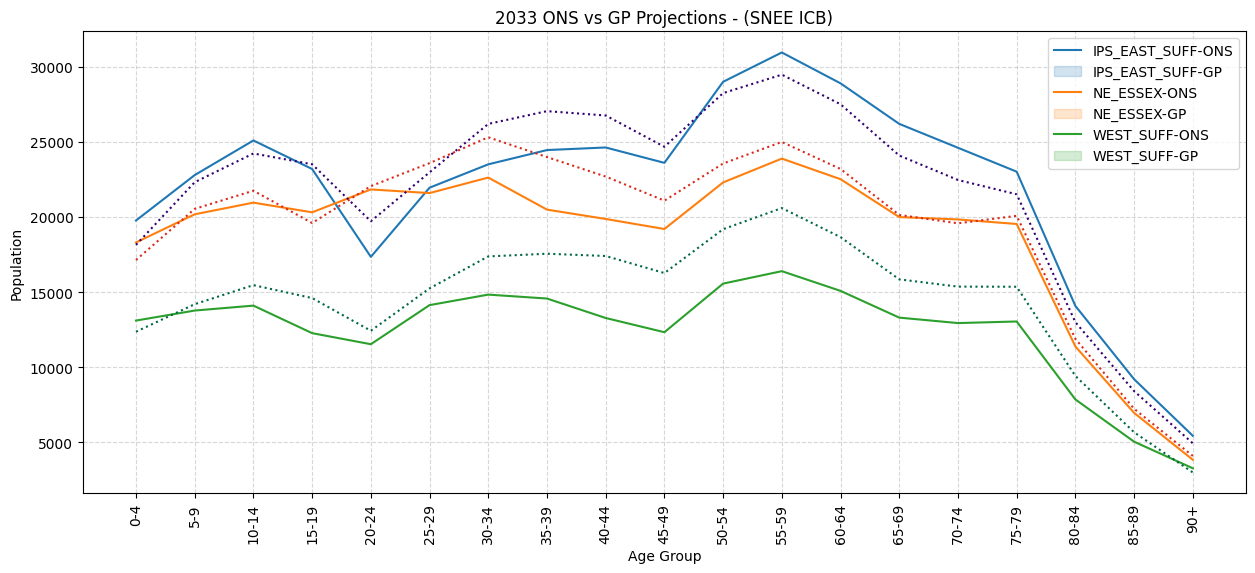

In [62]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Age Group')
plt.ylabel('Population')
plt.title('2033 ONS vs GP Projections - (SNEE ICB)')

custom_palette = sns.color_palette(["#330072", "#DA291C", "#006747"])

sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2023-ONS_Projection', hue='AREA_CODE')
sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2023-GP_Projection', hue='AREA_CODE', linestyle=':', palette=custom_palette)

plt.legend(labels=['IPS_EAST_SUFF-ONS','IPS_EAST_SUFF-GP', 'NE_ESSEX-ONS', 'NE_ESSEX-GP', 'WEST_SUFF-ONS', 'WEST_SUFF-GP'])

- We can see that ONS-Projections are close with GP-Patients list at older age groups for all 3 sub icb's
- For all 3 sub-icb's between age 20-24 to 45-49 the ONS-Projections are significantly lower that GP Patients list.
- For West Suffolk the GP Patients list are higher than ONS Projections except when the population is in age bands 0-4 and 90+

### **Lineplot between 2033: ONS Projections VS GP Projections**

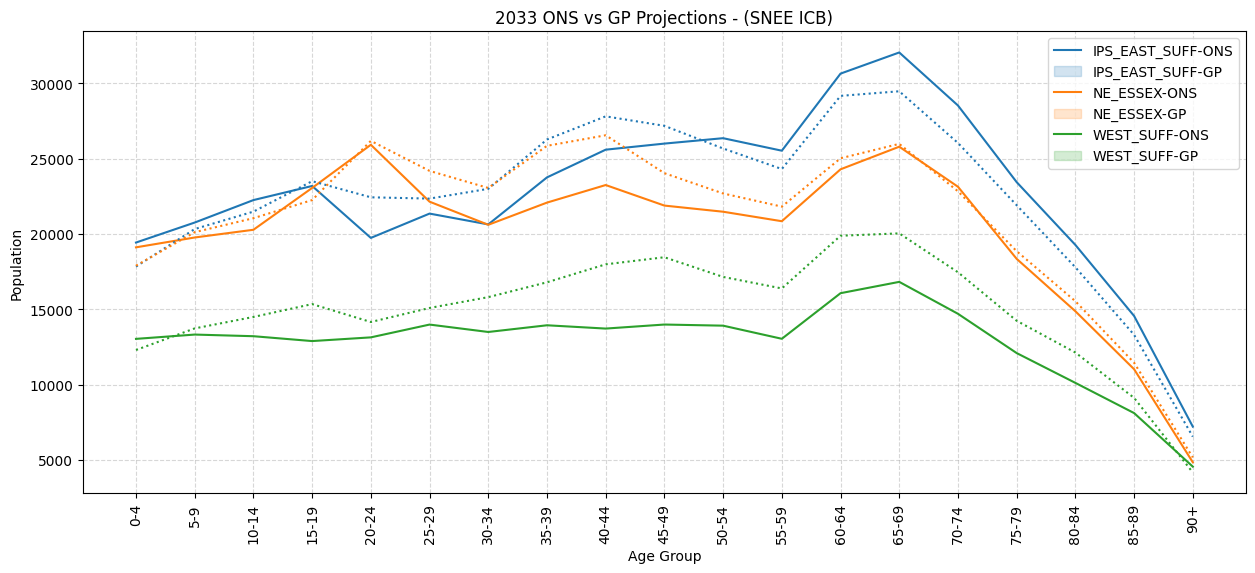

In [61]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Age Group')
plt.ylabel('Population')
plt.title('2033 ONS vs GP Projections - (SNEE ICB)')

sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2033-ONS_Projection', hue='AREA_CODE')
sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2033-GP_Projection', hue='AREA_CODE', linestyle=':')

plt.legend(labels=['IPS_EAST_SUFF-ONS','IPS_EAST_SUFF-GP', 'NE_ESSEX-ONS', 'NE_ESSEX-GP', 'WEST_SUFF-ONS', 'WEST_SUFF-GP'])

* For North East Essex the GP Projections are very close to the ONS Projections from age group 0-4 to 20-24 and varies after than until almost collides from age group 65-69 until 90+
* For Ipswich and East Suffolk the GP projections are slightly lower than the ONS Projections from age group 50-54 until 90+
* For West Suffolk the GP Projections are higher than ONS Projections except when the population is in age bands 0-4 and 90+

### **Lineplot between 2023 GP Patients list and 2033 GP Projections**

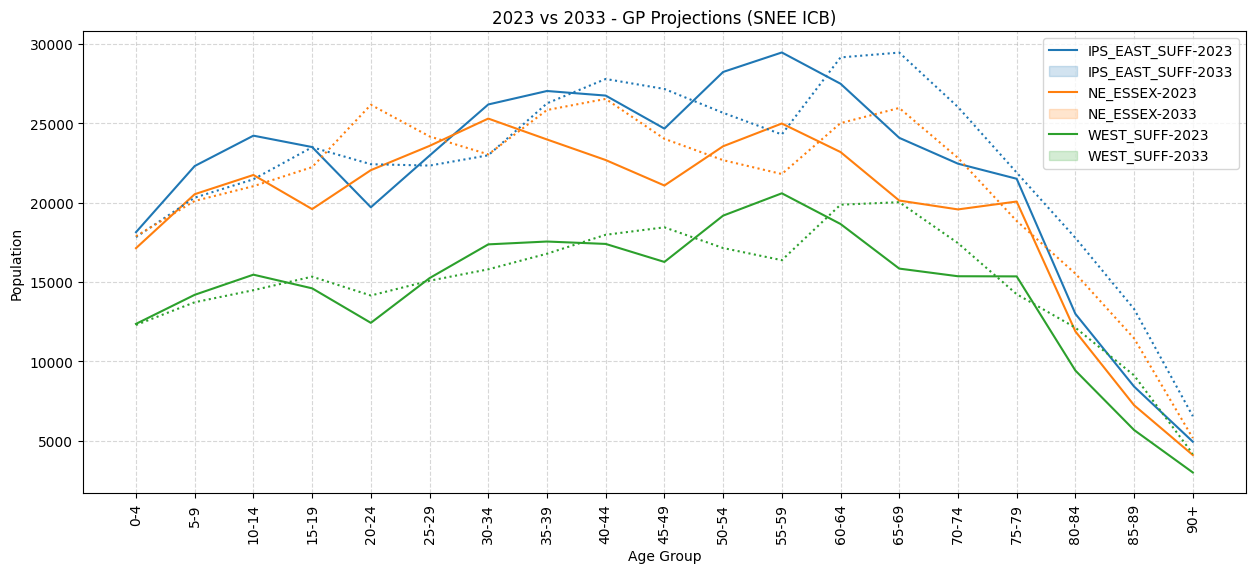

In [59]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Age Group')
plt.ylabel('Population')
plt.title('2023 vs 2033 - GP Projections (SNEE ICB)')

sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2023-GP_Projection', hue='AREA_CODE')
sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2033-GP_Projection', hue='AREA_CODE', linestyle=':')

plt.legend(labels=['IPS_EAST_SUFF-2023','IPS_EAST_SUFF-2033', 'NE_ESSEX-2023', 'NE_ESSEX-2033', 'WEST_SUFF-2023', 'WEST_SUFF-2033'])

* The peak for GP_Projections 2033 in West suffolk and Ipswich & East Suffolk is at 65-69 and the peak for year 2023 is at 55-59, which is expected as we are comparing 10 years difference in projections
* The overall population projection is pointing towards the population getting older and confined to older age bands

### **Lineplot between 2023 ONS Projections and 2033 ONS Projections**

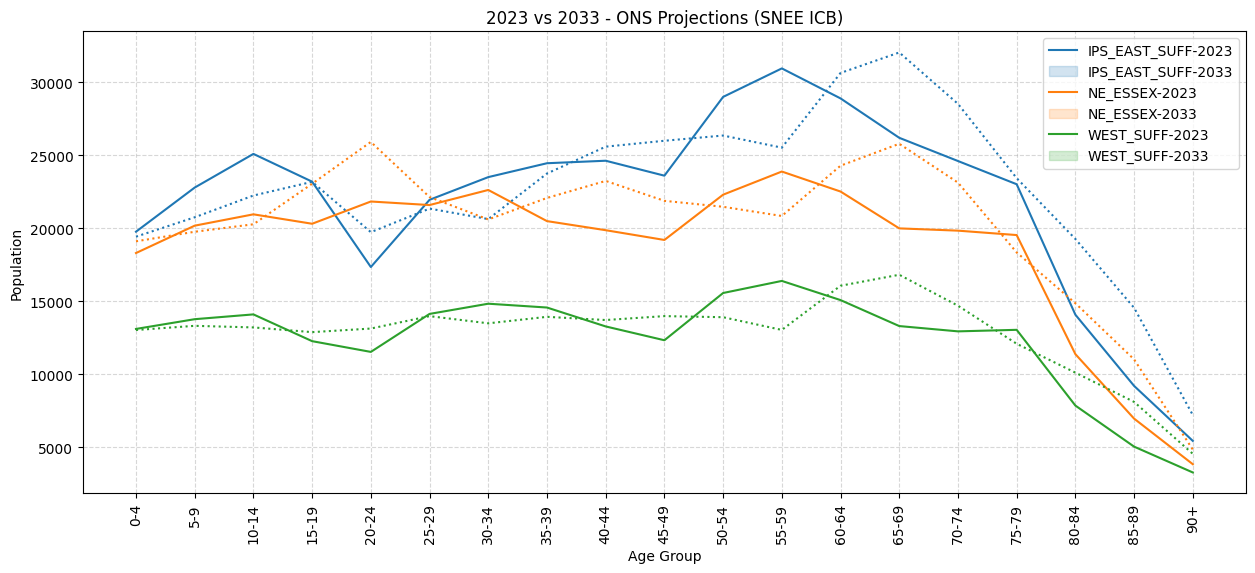

In [60]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Age Group')
plt.ylabel('Population')
plt.title('2023 vs 2033 - ONS Projections (SNEE ICB)')

sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2023-ONS_Projection', hue='AREA_CODE')
sns.lineplot(data=combined_df, x='AGE_GROUP_5', y='2033-ONS_Projection', hue='AREA_CODE', linestyle=':')

plt.legend(labels=['IPS_EAST_SUFF-2023','IPS_EAST_SUFF-2033', 'NE_ESSEX-2023', 'NE_ESSEX-2033', 'WEST_SUFF-2023', 'WEST_SUFF-2033'])

## **Implementing the same for other ONS scenarios**

In [19]:
def generate_factors(x):
    
    ons_projection_catalog_entry = catalog.scenario_data_sources[0].scenarios[x]
    ons_projections = ons_projection_catalog_entry.load()
    print(ons_projection_catalog_entry.zip_file.namelist())
    print(ons_projections.shape)
    
    #Filtering the dataset to remove values corresponding to 'All ages' in the 'AGE_GROUP' column and dropping the unused columns
    ons_projections_df = ons_projections.loc[ons_projections['AGE_GROUP']!='All ages'].drop(columns=['AREA_NAME','COMPONENT','SEX','2018','2019','2020','2021','2022']).set_index('AREA_CODE')

    #Replacing '90 and over' with 90 in age column
    ons_projections_df['AGE_GROUP'] = ons_projections_df['AGE_GROUP'].replace('90 and over', 90)
    
    #Creating bins and labels for AGE_BANDS
    bins = [-1,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,float('inf')]
    labels = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90+']

    #Converting AGE_GROUP data type to int
    ons_projections_df['AGE_GROUP'] = ons_projections_df['AGE_GROUP'].astype(int)

    #Adding the column for Age Bands as 'AGE_GROUP_5'
    ons_projections_df['AGE_GROUP_5'] = pd.cut(ons_projections_df['AGE_GROUP'], bins=bins, labels=labels)
    
    #Filtering the data to keep only SNEE ICB
    required_icb = ['E38000086','E38000204','E38000117']
    snee_ons_projections = ons_projections_df[ons_projections_df.index.isin(required_icb)].groupby(['AREA_CODE', 'AGE_GROUP_5']).sum().drop(columns=['AGE_GROUP'])
    
    #Calculating the population change factor for all years keeping 2023 as baseline
    pop_baseline = snee_ons_projections['2023']
    snee_factors_ons_projections = snee_ons_projections.div(pop_baseline, axis=0).round(4)

    return snee_factors_ons_projections
    
df = generate_factors(1)
df.head()


['2018 SNPP CCG pop females.csv', '2018 SNPP CCG pop males.csv', '2018 SNPP CCG pop persons.csv', 'SNPP Z2 10year CCG Pop_read me.txt']
(17940, 31)


/tmp/ipykernel_1016/2066449701.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  snee_ons_projections = ons_projections_df[ons_projections_df.index.isin(required_icb)].groupby(['AREA_CODE', 'AGE_GROUP_5']).sum().drop(columns=['AGE_GROUP'])


2023    2024    2025    2026    2027    2028    2029  \
AREA_CODE AGE_GROUP_5                                                         
E38000086 0-4           1.0  0.9966  0.9920  0.9888  0.9865  0.9852  0.9843   
          5-9           1.0  0.9835  0.9681  0.9483  0.9374  0.9284  0.9254   
          10-14         1.0  0.9972  0.9885  0.9810  0.9694  0.9609  0.9454   
          15-19         1.0  1.0135  1.0313  1.0440  1.0498  1.0447  1.0407   
          20-24         1.0  0.9909  0.9922  1.0126  1.0409  1.0708  1.0899   

                         2030    2031    2032  ...    2034    2035    2036  \
AREA_CODE AGE_GROUP_5                          ...                           
E38000086 0-4          0.9841  0.9847  0.9866  ...  0.9940  0.9995  1.0062   
          5-9          0.9215  0.9187  0.9169  ...  0.9152  0.9152  0.9158   
          10-14        0.9314  0.9129  0.9026  ...  0.8914  0.8879  0.8853   
          15-19        1.0317  1.0273  1.0160  ...  0.9893  0.9732  0.9570   
          20-24        1.1139  1.1312  1.1443  ...  1.1487  1.1463  1.1422   

                         2037    2038    2039    2040    2041    2042    2043  
AREA_CODE AGE_GROUP_5                                                          
E38000086 0-4          1.0141  1.0230  1.0327  1.0426  1.0521  1.0607  1.0679  
          5-9          0.9176  0.9205  0.9245  0.9296  0.9358  0.9431  0.9513  
          10-14        0.8837  0.8829  0.8824  0.8824  0.8830  0.8849  0.8876  
          15-19        0.9461  0.9386  0.9356  0.9322  0.9299  0.9285  0.9278  
          20-24        1.1287  1.1176  1.1030  1.0881  1.0689  1.0553  1.0461  

[5 rows x 21 columns]

In [20]:
#Converting to Dictionary
dict_data = df.to_dict(orient='index')
dict_data

{('E38000086', '0-4'): {'2023': 1.0,
  '2024': 0.9966,
  '2025': 0.992,
  '2026': 0.9888,
  '2027': 0.9865,
  '2028': 0.9852,
  '2029': 0.9843,
  '2030': 0.9841,
  '2031': 0.9847,
  '2032': 0.9866,
  '2033': 0.9897,
  '2034': 0.994,
  '2035': 0.9995,
  '2036': 1.0062,
  '2037': 1.0141,
  '2038': 1.023,
  '2039': 1.0327,
  '2040': 1.0426,
  '2041': 1.0521,
  '2042': 1.0607,
  '2043': 1.0679},
 ('E38000086', '5-9'): {'2023': 1.0,
  '2024': 0.9835,
  '2025': 0.9681,
  '2026': 0.9483,
  '2027': 0.9374,
  '2028': 0.9284,
  '2029': 0.9254,
  '2030': 0.9215,
  '2031': 0.9187,
  '2032': 0.9169,
  '2033': 0.9159,
  '2034': 0.9152,
  '2035': 0.9152,
  '2036': 0.9158,
  '2037': 0.9176,
  '2038': 0.9205,
  '2039': 0.9245,
  '2040': 0.9296,
  '2041': 0.9358,
  '2042': 0.9431,
  '2043': 0.9513},
 ('E38000086', '10-14'): {'2023': 1.0,
  '2024': 0.9972,
  '2025': 0.9885,
  '2026': 0.981,
  '2027': 0.9694,
  '2028': 0.9609,
  '2029': 0.9454,
  '2030': 0.9314,
  '2031': 0.9129,
  '2032': 0.9026,
  '2033